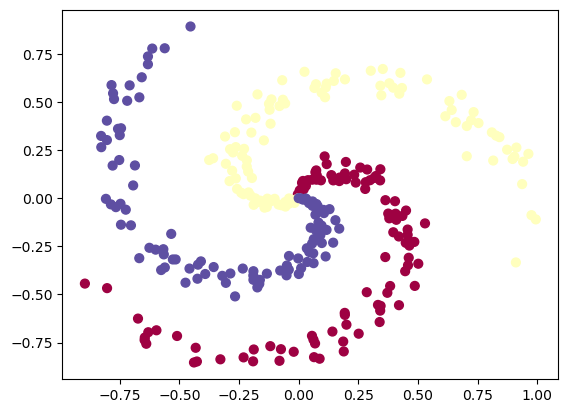

In [182]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [183]:
# Creating device agnostic code
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [184]:
# Performing a train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

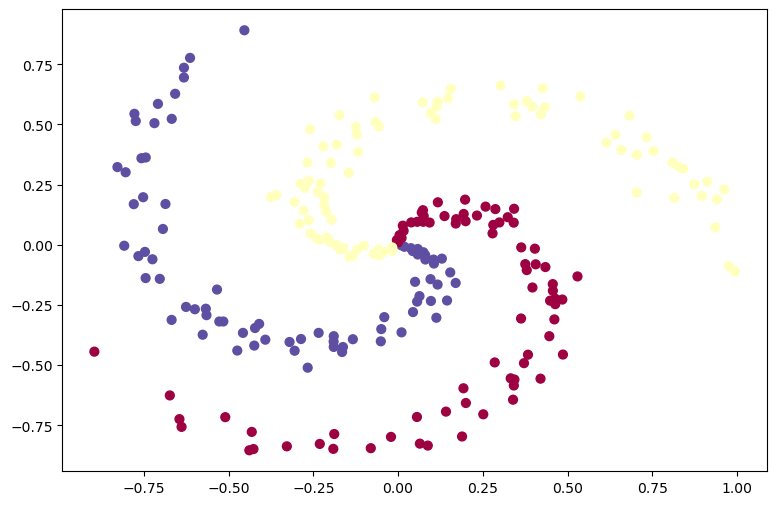

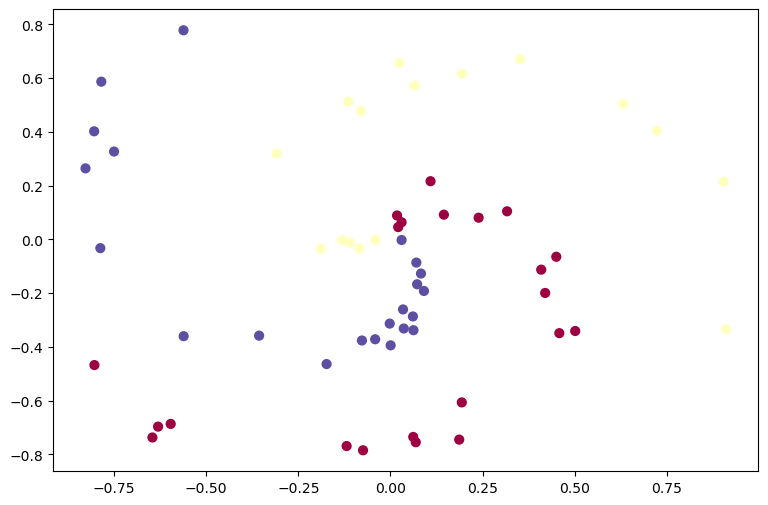

In [185]:
# Visualziing the train and test splits
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)

plt.figure(figsize=(20,6))
plt.subplot(1,2,2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)


In [186]:
# Creating the spiral model
from torch import nn

class SpiralModel(nn.Module):
    def __init__(self, hidden_units = 8):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=3)
        )

    
    def forward(self, x):
        return self.linear_stack(x)

model = SpiralModel().to(device)

In [187]:
# Defining the loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr = 1)

In [188]:
# Creating the training and testing loop
from torchmetrics.classification import Accuracy

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)



epochs = 1000

accuracy = Accuracy(task='multiclass', num_classes = 3)

for epoch in range(epochs):
    # Training
    model.train()

    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_pred = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = accuracy(y_test_pred, y_test)
    
    if epoch % 100 == 0:
        print(f'For Epoch {epoch}: Loss: {loss} | Acc: {acc} | Test Loss: {test_loss} | Test Acc: {test_acc}')



For Epoch 0: Loss: 1.0957926511764526 | Acc: 0.3333333432674408 | Test Loss: 1.086297869682312 | Test Acc: 0.4333333373069763
For Epoch 100: Loss: 0.6159303784370422 | Acc: 0.737500011920929 | Test Loss: 0.6481373310089111 | Test Acc: 0.6166666746139526
For Epoch 200: Loss: 0.2994898855686188 | Acc: 0.887499988079071 | Test Loss: 0.4027523398399353 | Test Acc: 0.8999999761581421
For Epoch 300: Loss: 0.1451084315776825 | Acc: 0.9583333134651184 | Test Loss: 0.34608349204063416 | Test Acc: 0.9333333373069763
For Epoch 400: Loss: 0.07861185818910599 | Acc: 0.9708333611488342 | Test Loss: 0.3439873158931732 | Test Acc: 0.9833333492279053
For Epoch 500: Loss: 0.062147047370672226 | Acc: 0.9750000238418579 | Test Loss: 0.3672032058238983 | Test Acc: 0.9833333492279053
For Epoch 600: Loss: 0.14360187947750092 | Acc: 0.949999988079071 | Test Loss: 0.3993404507637024 | Test Acc: 0.9166666865348816
For Epoch 700: Loss: 0.08577421307563782 | Acc: 0.9750000238418579 | Test Loss: 0.4188710749149322

In [189]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

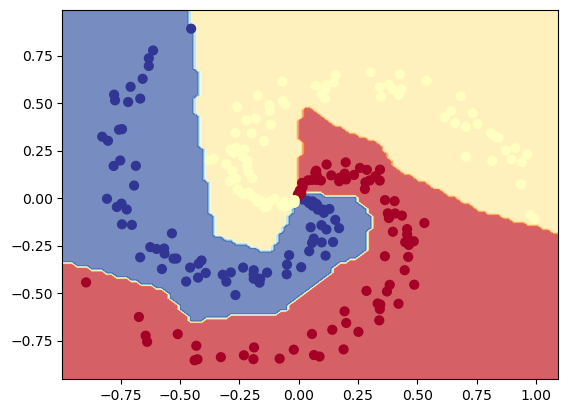

In [190]:
plot_decision_boundary(model, X_train, y_train)